In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import the required libraries
import numpy as np
import pickle
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras import backend as keras
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd

In [ ]:
"""

    Initialisation of Monte-Carlo Dropout UNet Model

"""

def UNet_MCD(input_size, reg_fn, dropout_rate):
    inputs = Input(shape=input_size)

    #Encoder Block 0
    conv1 = Conv2D(8, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #Encoder Block 1 
    conv2 = Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #Encoder Block 2
    drop2 = Dropout(dropout_rate)(pool1, training = False)
    conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #Encoder Block 3
    drop3 = Dropout(dropout_rate)(pool2, training = False)
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #Encoder Block 4
    drop4 = Dropout(dropout_rate)(pool3, training = False)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    #Encoder Block 5
    drop5 = Dropout(dropout_rate)(pool4, training = False)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool5)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    ### Decoder Blocks

    #Decoder Block 4
    drop4_1 = Dropout(dropout_rate)(pool5, training = False)
    up7 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(pool6)
    sc7 = Concatenate()([up7, pool5])

    #Decoder Block 3
    drop3_1 = Dropout(dropout_rate)(pool6, training = False)
    up8 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc7)
    sc8 = Concatenate()([up8, pool4])

    #Decoder Block 2
    drop2_1 = Dropout(dropout_rate)(sc7, training = False)
    up9 = Conv2DTranspose(32, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc8)
    sc9 = Concatenate()([up9, pool3])

    #Decoder Block 1
    up10 = Conv2DTranspose(16, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc9)
    sc10 = Concatenate()([up10, pool2])

    #Decoder Block 0
    up11 = Conv2DTranspose(8, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc10)
    sc11 = Concatenate()([up11, pool1])

    up12 = Conv2DTranspose(1, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc11)

    model = Model(inputs, up12)

    model.compile(optimizer='adam', metrics=['accuracy'], loss=tf.keras.losses.MeanSquaredError())

    return model

# 1e16 to 1e17

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

In [ ]:
y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_16_17.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_16_17.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_16_17.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

6e+16
8.626052
6.9957054e+16
7.518519e+16
5.927579e+16


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

109

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
x = range(m_test)
for i in range(num_img):
    Mean = []
    Dev = []
    for ii in range(256):
      dummy= []
      dummy.append(np.amax(pred[i,ii]))
      dummy.append(np.amax(pred1[i,ii]))
      dummy.append(np.amax(pred2[i,ii]))
      Mean.append(np.mean(dummy))
      Dev.append(np.std(dummy))
    Mean = np.array(Mean)
    Dev = np.array(Dev)
    x_axis_test = y_test[i][int(m_test/2)]
    x_axis_pred = pred[i][int(m_pred/2)]
    x_axis_pred1 = pred1[i][int(m_pred/2)]
    x_axis_pred2 = pred2[i][int(m_pred/2)]
    plt.figure()
    plt.title("Density Profile {}".format(i), fontsize=15)
    plt.ylabel("Density", fontsize=15,labelpad=7)
    plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
    plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    plt.fill_between(x,(Mean + (2*Dev)), (Mean - (2*Dev)),color='cyan',label='Confidence Region')
    plt.legend(fontsize=10)

Output hidden; open in https://colab.research.google.com to view.

# 1e17 to 1e18

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_17_18.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_17_18.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_17_18.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

9.5e+17
10.634701
9.389926e+17
9.421668e+17
9.341432e+17


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

116

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
x = range(m_test)
for i in range(num_img):
    Mean = []
    Dev = []
    for ii in range(256):
      dummy= []
      dummy.append(np.amax(pred[i,ii]))
      dummy.append(np.amax(pred1[i,ii]))
      dummy.append(np.amax(pred2[i,ii]))
      Mean.append(np.mean(dummy))
      Dev.append(np.std(dummy))
    Mean = np.array(Mean)
    Dev = np.array(Dev)
    x_axis_test = y_test[i][int(m_test/2)]
    x_axis_pred = pred[i][int(m_pred/2)]
    x_axis_pred1 = pred1[i][int(m_pred/2)]
    x_axis_pred2 = pred2[i][int(m_pred/2)]
    plt.figure()
    plt.title("Density Profile {}".format(i), fontsize=15)
    plt.ylabel("Density", fontsize=15,labelpad=7)
    plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
    plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    plt.fill_between(x,(Mean + (2*Dev)), (Mean - (2*Dev)),color='cyan',label='Confidence Region')
    plt.legend(fontsize=10)

Output hidden; open in https://colab.research.google.com to view.

# 1e18 to 1e19

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_18_19.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_18_19.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_18_19.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

6.0000003e+18
12.079081
5.9465327e+18
6.1008635e+18
5.866674e+18


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

105

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
x = range(m_test)
for i in range(num_img):
    Mean = []
    Dev = []
    for ii in range(256):
      dummy= []
      dummy.append(np.amax(pred[i,ii]))
      dummy.append(np.amax(pred1[i,ii]))
      dummy.append(np.amax(pred2[i,ii]))
      Mean.append(np.mean(dummy))
      Dev.append(np.std(dummy))
    Mean = np.array(Mean)
    Dev = np.array(Dev)
    x_axis_test = y_test[i][int(m_test/2)]
    x_axis_pred = pred[i][int(m_pred/2)]
    x_axis_pred1 = pred1[i][int(m_pred/2)]
    x_axis_pred2 = pred2[i][int(m_pred/2)]
    plt.figure()
    plt.title("Density Profile {}".format(i), fontsize=15)
    plt.ylabel("Density", fontsize=15,labelpad=7)
    plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
    plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    plt.fill_between(x,(Mean + (2*Dev)), (Mean - (2*Dev)),color='cyan',label='Confidence Region')
    plt.legend(fontsize=10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

In [ ]:
y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_18_19.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_18_19.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_18_19.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

6.0000003e+18
12.079081
5.9465327e+18
6.1008635e+18
5.866674e+18


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

105

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
x = range(m_test)
for i in range(num_img):
    Mean = []
    Dev = []
    for ii in range(256):
      dummy= []
      #dummy.append(np.amax(pred[i,ii]))
      dummy.append(np.amax(pred1[i,ii]))
      dummy.append(np.amax(pred2[i,ii]))
      Mean.append(np.mean(dummy))
      Dev.append(np.std(dummy))
    Mean = np.array(Mean)
    Dev = np.array(Dev)
    x_axis_test = y_test[i][int(m_test/2)]
    x_axis_pred = pred[i][int(m_pred/2)]
    x_axis_pred1 = pred1[i][int(m_pred/2)]
    x_axis_pred2 = pred2[i][int(m_pred/2)]
    plt.figure()
    plt.title("Density Profile {}".format(i), fontsize=15)
    plt.ylabel("Density", fontsize=15,labelpad=7)
    plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
    plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    #plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    plt.fill_between(x,(Mean + (2*Dev)), (Mean - (2*Dev)),color='cyan',label='Confidence Region')
    plt.legend(fontsize=10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

In [ ]:
y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_16_17.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_16_17.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_16_17.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

6e+16
8.626052
6.9957054e+16
7.518519e+16
5.927579e+16


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

109

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
x = range(m_test)
for i in range(num_img):
    Mean = []
    Dev = []
    for ii in range(256):
      dummy= []
      dummy.append(np.amax(pred[i,ii]))
      dummy.append(np.amax(pred1[i,ii]))
      dummy.append(np.amax(pred2[i,ii]))
      
      Mean.append(np.mean(dummy))
      Dev.append(np.std(dummy))
    Mean = np.array(Mean)
    Dev = np.array(Dev)
    x_axis_test = y_test[i][int(m_test/2)]
    x_axis_pred = pred[i][int(m_pred/2)]
    x_axis_pred1 = pred1[i][int(m_pred/2)]
    x_axis_pred2 = pred2[i][int(m_pred/2)]
    plt.figure()
    plt.title("Density Profile {}".format(i), fontsize=15)
    plt.ylabel("Density", fontsize=15,labelpad=7)
    plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
    #plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    plt.fill_between(x,(Mean + (2*Dev)), (Mean - (2*Dev)),color='cyan',label='Confidence Region')
    plt.legend(fontsize=10)

Output hidden; open in https://colab.research.google.com to view.

# **Monte Carlo Dropout Rate = 0.5**

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

In [ ]:
y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_16_17.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_16_17.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_16_17.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

pred3 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_3/1e-06_MC_pred_P3_16_17.npz')
pred3 = pred3['arr_0']
pred3 = pred3.astype('float32')

pred4 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_4/1e-06_MC_pred_P4_16_17.npz')
pred4 = pred4['arr_0']
pred4 = pred4.astype('float32')

pred5 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_5/1e-06_MC_pred_P5_16_17.npz')
pred5 = pred5['arr_0']
pred5 = pred5.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

pred3 /= 255.0
pred3 = pred3*max_val_den
print(np.amax(pred3[22]))

pred4 /= 255.0
pred4 = pred4*max_val_den
print(np.amax(pred4[22]))

pred5 /= 255.0
pred5 = pred5*max_val_den
print(np.amax(pred5[22]))

6e+16
8.626052
6.9957054e+16
7.518519e+16
5.927579e+16
5.661199e+16
6.51305e+16
7.1633174e+16


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

109

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
import math 

530924930000000.0

In [ ]:
z1 = 1.28   # Z score for 80% confidence
z2 = 1.645  # Z score for 90% confidence
z3 = 1.96   # Z score for 95% confidence
Upper = np.zeros(256)
Lower = np.zeros(256)


for i in range(num_img):
  Dummy = np.array
  for ii in range(256):
    Dummy.append((pred[i]))
  mean = np.mean(Dummy)
  dev = np.std(Dummy)
  Upper[ii] = (mean + (z1*(dev/math.sqrt(num_img))))
  Lower[ii] = (mean - (z1*(dev/math.sqrt(num_img))))

i= 100
x_axis_test = y_test[i][int(m_test/2)]
x_axis_pred = pred[i][int(m_pred/2)]
plt.figure()
plt.title("Density Profile {}".format(i), fontsize=15)
plt.ylabel("Density", fontsize=15,labelpad=7)
plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
  # plt.plot(x,(Mean - (z1*(Dev)/math.sqrt(6))),color='magenta', label='Lower Bound')
  # plt.plot(x,(Mean + (z1*(Dev)/math.sqrt(6))),color='magenta', label='Upper Bound')
plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
      # plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
      # plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
      # plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
      # plt.plot(x, x_axis_pred3, label='Dropout rate = 0.3')
      # plt.plot(x, x_axis_pred4, label='Dropout rate = 0.4')
plt.plot(x,Upper,label='Confidence Region')
plt.plot(x,Lower,label='Confidence Region')

# plt.yscale('log')
plt.legend(fontsize=10)


AttributeError: ignored

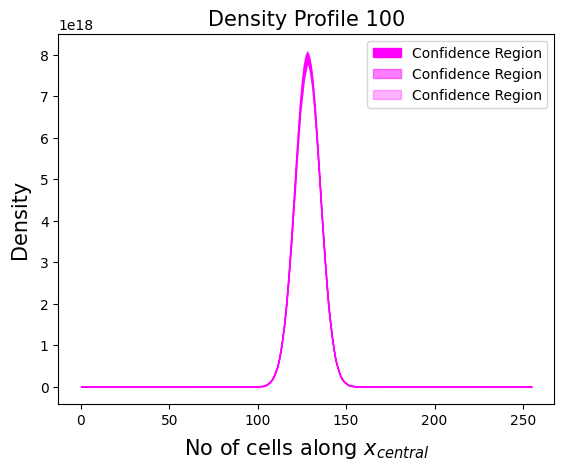

In [ ]:
x = range(m_test)
i = 100
z1 = 1.28   # Z score for 80% confidence
z2 = 1.645  # Z score for 90% confidence
z3 = 1.96   # Z score for 95% confidence
#for i in range(num_img):
Mean = []
Dev = []
for ii in range(256):
  dummy= []
  dummy.append(np.amax(pred[i,ii]))
  dummy.append(np.amax(pred1[i,ii]))
  dummy.append(np.amax(pred2[i,ii]))
  dummy.append(np.amax(pred3[i,ii]))
  dummy.append(np.amax(pred4[i,ii]))
  dummy.append(np.amax(pred5[i,ii]))
  Mean.append(np.mean(dummy))
  Dev.append(np.std(dummy))
Mean = np.array(Mean)
Dev = np.array(Dev)
x_axis_test = y_test[i][int(m_test/2)]
x_axis_pred = pred[i][int(m_pred/2)]
x_axis_pred1 = pred1[i][int(m_pred/2)]
x_axis_pred2 = pred2[i][int(m_pred/2)]
x_axis_pred3 = pred3[i][int(m_pred/2)]
x_axis_pred4 = pred4[i][int(m_pred/2)]
x_axis_pred5 = pred5[i][int(m_pred/2)]
plt.figure()
plt.title("Density Profile {}".format(i), fontsize=15)
plt.ylabel("Density", fontsize=15,labelpad=7)
plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
# plt.plot(x,(Mean - (z1*(Dev)/math.sqrt(6))),color='magenta', label='Lower Bound')
# plt.plot(x,(Mean + (z1*(Dev)/math.sqrt(6))),color='magenta', label='Upper Bound')
# plt.plot(x, x_axis_test, color='Black',linewidth=0.5,label='Ground Truth')
    # plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    # plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    # plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    # plt.plot(x, x_axis_pred3, label='Dropout rate = 0.3')
    # plt.plot(x, x_axis_pred4, label='Dropout rate = 0.4')
plt.fill_between(x,(Mean - (z1*(Dev)/math.sqrt(6))), (Mean + (z1*(Dev)/math.sqrt(6))),color='magenta',label='Confidence Region')
plt.fill_between(x,(Mean - (z2*(Dev)/math.sqrt(6))), (Mean + (z2*(Dev)/math.sqrt(6))),color='magenta',alpha=0.5,label='Confidence Region')
plt.fill_between(x,(Mean - (z3*(Dev)/math.sqrt(6))), (Mean + (z3*(Dev)/math.sqrt(6))),color='magenta',alpha=0.3,label='Confidence Region')
# plt.yscale('log')
plt.legend(fontsize=10)
plt.savefig('Density_Profiles_MC_P_5_16_17_' + str(i) + '_.png')

In [ ]:
!rm -r Density_Profiles*

## 1e17 to 1e18

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

In [ ]:
y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_17_18.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_17_18.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_17_18.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

pred3 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_3/1e-06_MC_pred_P3_17_18.npz')
pred3 = pred3['arr_0']
pred3 = pred3.astype('float32')

pred4 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_4/1e-06_MC_pred_P4_17_18.npz')
pred4 = pred4['arr_0']
pred4 = pred4.astype('float32')

pred5 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_5/1e-06_MC_pred_P5_17_18.npz')
pred5 = pred5['arr_0']
pred5 = pred5.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

pred3 /= 255.0
pred3 = pred3*max_val_den
print(np.amax(pred3[22]))

pred4 /= 255.0
pred4 = pred4*max_val_den
print(np.amax(pred4[22]))

pred5 /= 255.0
pred5 = pred5*max_val_den
print(np.amax(pred5[22]))

9.5e+17
10.634701
9.389926e+17
9.421668e+17
9.341432e+17
9.644801e+17
9.570936e+17
9.4510096e+17


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

116

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
!mkdir Density_Profiles_MC_P_5_17_18

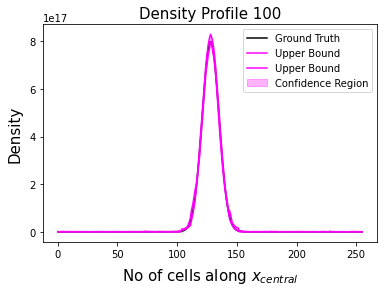

In [ ]:
x = range(m_test)
i = 100
#for i in range(num_img):
Mean = []
Dev = []
for ii in range(256):
  dummy= []
  dummy.append(np.amax(pred[i,ii]))
  dummy.append(np.amax(pred1[i,ii]))
  dummy.append(np.amax(pred2[i,ii]))
  dummy.append(np.amax(pred3[i,ii]))
  dummy.append(np.amax(pred4[i,ii]))
  dummy.append(np.amax(pred5[i,ii]))
  Mean.append(np.mean(dummy))
  Dev.append(np.std(dummy))
Mean = np.array(Mean)
Dev = np.array(Dev)
x_axis_test = y_test[i][int(m_test/2)]
x_axis_pred = pred[i][int(m_pred/2)]
x_axis_pred1 = pred1[i][int(m_pred/2)]
x_axis_pred2 = pred2[i][int(m_pred/2)]
x_axis_pred3 = pred3[i][int(m_pred/2)]
x_axis_pred4 = pred4[i][int(m_pred/2)]
x_axis_pred5 = pred5[i][int(m_pred/2)]
plt.figure()
plt.title("Density Profile {}".format(i), fontsize=15)
plt.ylabel("Density", fontsize=15,labelpad=7)
plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    # plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    # plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    # plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    # plt.plot(x, x_axis_pred3, label='Dropout rate = 0.3')
    # plt.plot(x, x_axis_pred4, label='Dropout rate = 0.4')
plt.plot(x,(Mean + (Dev)),color='magenta', label='Upper Bound')
plt.plot(x,(Mean - (Dev)),color='magenta', label='Upper Bound')
plt.fill_between(x,(Mean + (Dev)), (Mean - (Dev)),alpha=0.3,color='magenta',label='Confidence Region')
plt.legend(fontsize=10)
plt.savefig('Density_Profiles_MC_P_5_17_18_' + str(i) + '_.png')

## 1e18 to 1e19

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

In [ ]:
y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

pred = np.load('/content/drive/MyDrive/Rings_without_Noise/1e-06_pred_18_19.npz')
pred = pred['arr_0']
pred = pred.astype('float32')

pred1 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MC_pred_18_19.npz')
pred1 = pred1['arr_0']
pred1 = pred1.astype('float32')

pred2 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_2/1e-06_MC_pred_P2_18_19.npz')
pred2 = pred2['arr_0']
pred2 = pred2.astype('float32')

pred3 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_3/1e-06_MC_pred_P3_18_19.npz')
pred3 = pred3['arr_0']
pred3 = pred3.astype('float32')

pred4 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_4/1e-06_MC_pred_P4_18_19.npz')
pred4 = pred4['arr_0']
pred4 = pred4.astype('float32')

pred5 = np.load('/content/drive/MyDrive/Rings_without_Noise/MC_P_5/1e-06_MC_pred_P5_18_19.npz')
pred5 = pred5['arr_0']
pred5 = pred5.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
y_test = y_test/255.0
y_test = y_test*max_val_den
print(np.amax(y_test[22]))

x_test = x_test/255.0
x_test = x_test*max_val_erms
print(np.amax(x_test[22]))

pred /= 255.0
pred = pred*max_val_den
print(np.amax(pred[22]))

pred1 /= 255.0
pred1 = pred1*max_val_den
print(np.amax(pred1[22]))

pred2 /= 255.0
pred2 = pred2*max_val_den
print(np.amax(pred2[22]))

pred3 /= 255.0
pred3 = pred3*max_val_den
print(np.amax(pred3[22]))

pred4 /= 255.0
pred4 = pred4*max_val_den
print(np.amax(pred4[22]))

pred5 /= 255.0
pred5 = pred5*max_val_den
print(np.amax(pred5[22]))

6.0000003e+18
12.079081
5.9465327e+18
6.1008635e+18
5.866674e+18
5.785905e+18
5.995214e+18
6.019803e+18


In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

105

In [ ]:
m_pred = pred.shape[1]
n_pred = pred.shape[2]

In [ ]:
!mkdir Density_Profiles_MC_P_5_18_19

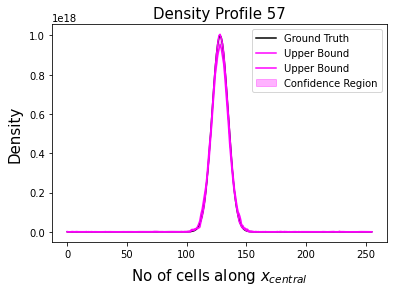

In [ ]:
x = range(m_test)
i = 57
#for i in range(num_img):
Mean = []
Dev = []
for ii in range(256):
  dummy= []
  dummy.append(np.amax(pred[i,ii]))
  dummy.append(np.amax(pred1[i,ii]))
  dummy.append(np.amax(pred2[i,ii]))
  dummy.append(np.amax(pred3[i,ii]))
  dummy.append(np.amax(pred4[i,ii]))
  dummy.append(np.amax(pred5[i,ii]))
  Mean.append(np.mean(dummy))
  Dev.append(np.std(dummy))
Mean = np.array(Mean)
Dev = np.array(Dev)
x_axis_test = y_test[i][int(m_test/2)]
x_axis_pred = pred[i][int(m_pred/2)]
x_axis_pred1 = pred1[i][int(m_pred/2)]
x_axis_pred2 = pred2[i][int(m_pred/2)]
x_axis_pred3 = pred3[i][int(m_pred/2)]
x_axis_pred4 = pred4[i][int(m_pred/2)]
x_axis_pred5 = pred5[i][int(m_pred/2)]
plt.figure()
plt.title("Density Profile {}".format(i), fontsize=15)
plt.ylabel("Density", fontsize=15,labelpad=7)
plt.xlabel("No of cells along $x_{central}$", fontsize=15,labelpad=7)
plt.plot(x, x_axis_test, color='Black',label='Ground Truth')
    # plt.plot(x, x_axis_pred, color='red',label='Model Prediction')
    # plt.plot(x, x_axis_pred1, color='blue', label='Dropout rate = 0.1')
    # plt.plot(x, x_axis_pred2, label='Dropout rate = 0.2')
    # plt.plot(x, x_axis_pred3, label='Dropout rate = 0.3')
    # plt.plot(x, x_axis_pred4, label='Dropout rate = 0.4')
plt.plot(x,(Mean + (Dev)),color='magenta', label='Upper Bound')
plt.plot(x,(Mean - (Dev)),color='magenta', label='Upper Bound')
plt.fill_between(x,(Mean + (Dev)), (Mean - (Dev)),alpha=0.3,color='magenta',label='Confidence Region')
plt.legend(fontsize=10)
plt.savefig('Density_Profiles_MC_P_5_18_19_' + str(57) + '_.png')

In [ ]:
from google.colab import files

In [ ]:
!zip -r /content/Density_Profiles_MC_P_5_18_19.zip /content/Density_Profiles_MC_P_5_18_19
!zip -r /content/Density_Profiles_MC_P_5_17_18.zip /content/Density_Profiles_MC_P_5_17_18
!zip -r /content/Density_Profiles_MC_P_5_16_17.zip /content/Density_Profiles_MC_P_5_16_17

  adding: content/Density_Profiles_MC_P_5_18_19/ (stored 0%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_75_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_22_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_60_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_51_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_98_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_102_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_4_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_56_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P_5_18_19/Density_Profiles_MC_P_5_18_19_43_.png (deflated 3%)
  adding: content/Density_Profiles_MC_P

In [ ]:
files.download("/content/Density_Profiles_MC_P_5_18_19.zip")
files.download("/content/Density_Profiles_MC_P_5_17_18.zip")
files.download("/content/Density_Profiles_MC_P_5_16_17.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.subplot()